In [1]:
import numpy as np
np.seterr(all='raise')
import sys
sys.path.append('../')

from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.mesh import Mesh
from meshmaker.pmesh import ParamMesh, MetaMesh, MetaScene
#from meshmaker.meta import Railing, Stairs
from meshmaker.tform import TForm
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.loop import loops as Loops
from meshmaker.delaunay import triangulation
from meshmaker.planargraph import planargraph
#from meshmaker.geometry import batch, slide, loop_offset, loop_normal, loop_contains, loop_split, isnear, near, loopO
from meshmaker.geometry import batch, slide, isnear, near, sintsxyp
from meshmaker.mgl import show, MainShader, EdgeShader, WireShader, LazyMaterials
from meshmaker.plt import *
from collections import defaultdict
from functools import partial, reduce
import json

show = partial(show, programs=[MainShader(), EdgeShader(), WireShader(color=vec3.U(0.1))], background=vec3.U(0.8))

# want to version of embed

    strict - hole is not allowed to modify parent contour and cannot join existing holes
    clip   - hole is allowed to modify parent contour and/or join existing holes

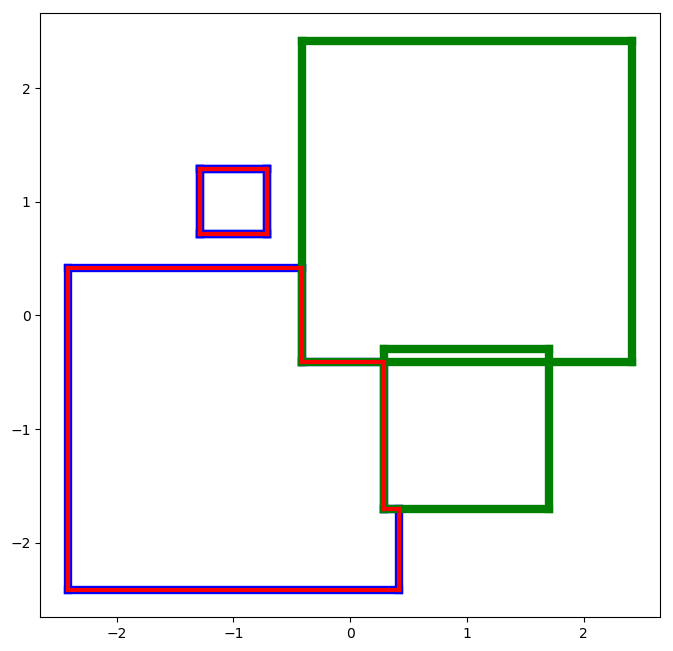

In [2]:
class Support(Loops):
    
    def embed(self, other):
        """Add as hole or modify self"""
        
        diff = self.difference(other)
        return diff


A = vec3(-1, -1, 0).ring(2, 4, True)
#B = vec3(-1, -1, 0).ring(1, 4, True)
B = vec3( 1,  1, 0).ring(2, 4, True)
C = vec3( 1, -1, 0).ring(1, 4, True)
D = vec3(-1,  1, 0).ring(0.4, 4, True)

a = Support([A, D])
b = Support([B, C])

#c = a.embed(b)
c = a.difference(b)

f, ax = plot()
a.plot(ax, col='b', lw=6)
b.plot(ax, col='g', lw=6)
c.plot(ax, col='r', lw=3)


In [3]:
# proper loop containment check

# organized pg.loops output into tree of contours for Polygons instance

# pg.polygon needs to output a tree of contours

clip self to hole


AttributeError: 'NoneType' object has no attribute 'plot'

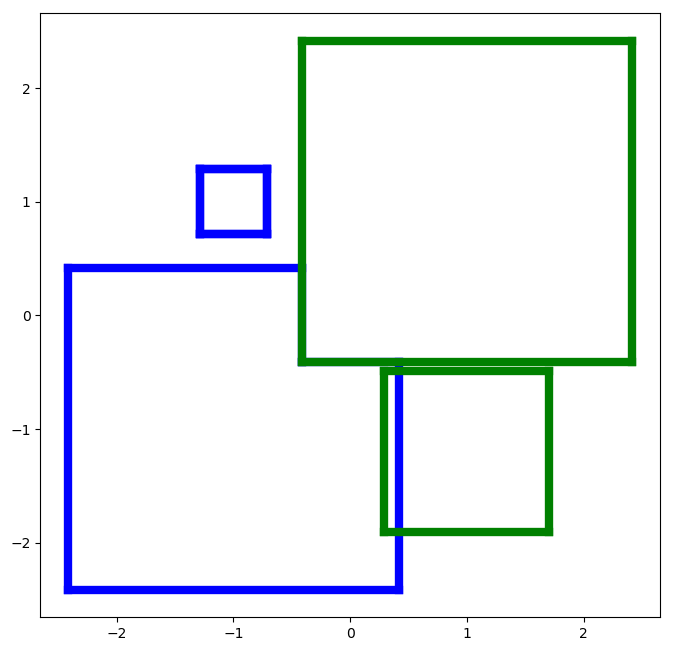

In [3]:
A = vec3(-1, -1, 0).ring(2, 4, True)
#B = vec3(-1, -1, 0).ring(1, 4, True)
B = vec3( 1,  1, 0).ring(2, 4, True)
C = vec3( 1, -1.2, 0).ring(1, 4, True)
D = vec3(-1,  1, 0).ring(0.4, 4, True)
E = vec3( 1,  1, 0).ring(0.4, 4, True)

a = Loops([A, D, E])
b = Loops([B, C])

c = a.embed(B, mode='clip')
#c = a.cp().difference(b, True)
#c = a.intersect(b)
#c = a.union(b)

f, ax = plot()
a.plot(ax, col='b', lw=6)
b.plot(ax, col='g', lw=6)
c.plot(ax, col='r', lw=3)

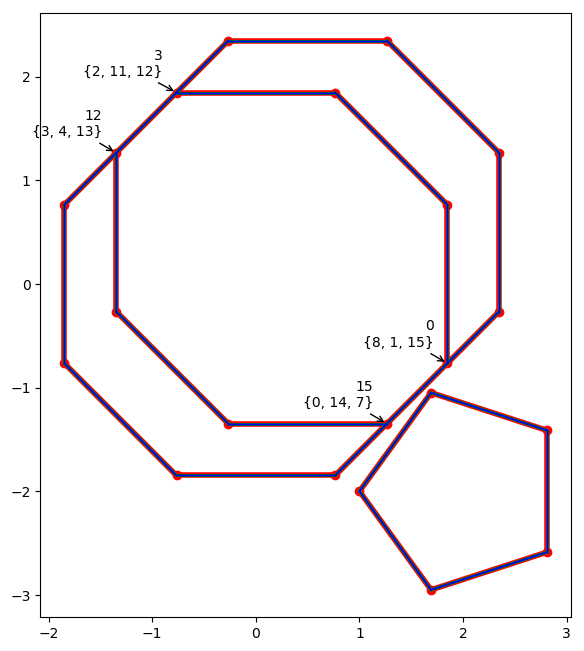

In [4]:
a = vec3.O().ring(2, 8)
b = vec3.U(0.5).xy().ring(2, 8)
c = vec3(2, -2, 0).ring(1, 5, True)

segs = [x for y in (a, b, c) for x in slide(y, 2)]
#segs = list(slide(a, 2)) + list(slide(b, 2))

pg = planargraph(segs=segs)

loops = pg.loops()
loops = [[pg.vertices[v] for v in l] for l in loops]

py = pg.polygon()

f, ax = plot()
ax.set_aspect(1)
plot_pg(ax, pg, lw=4, col='r')
for l in loops:
    plot_loop(ax, l, col='g', lw=2)
    
plot_loop(ax, py[0], col='b', lw=1)
for l in py[1]:
    plot_loop(ax, l, col='b', lw=1)

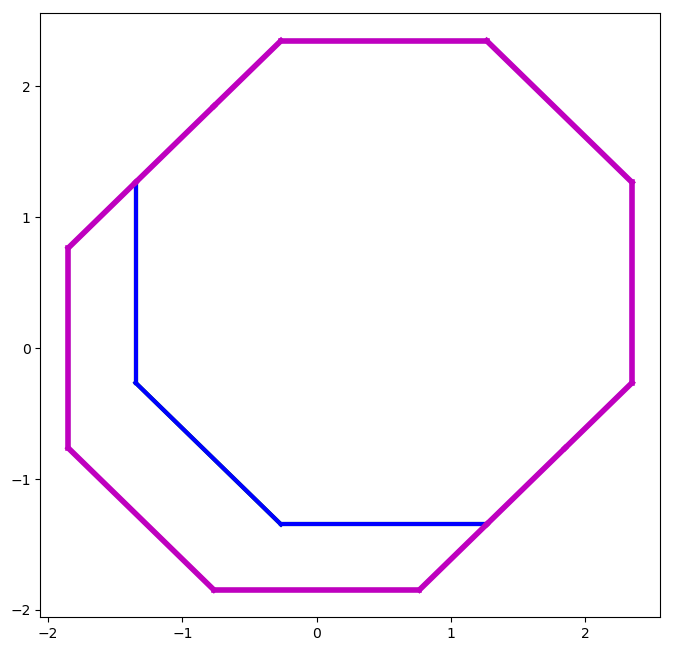

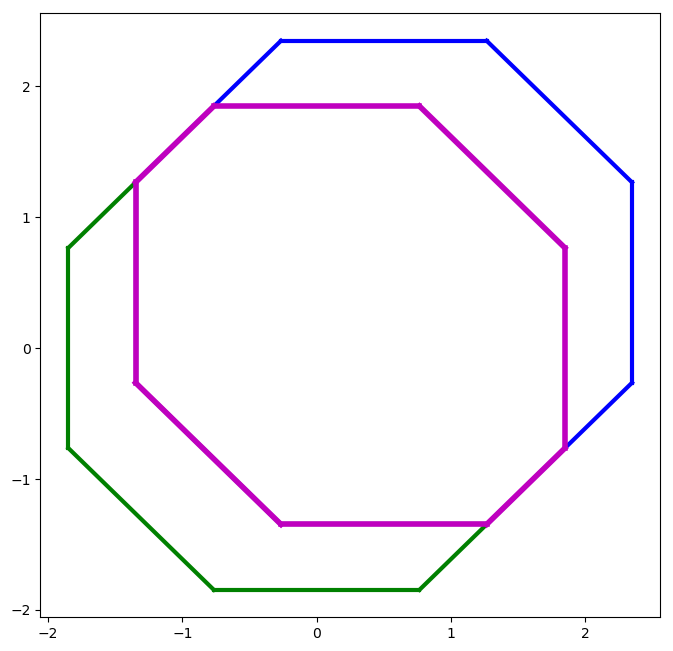

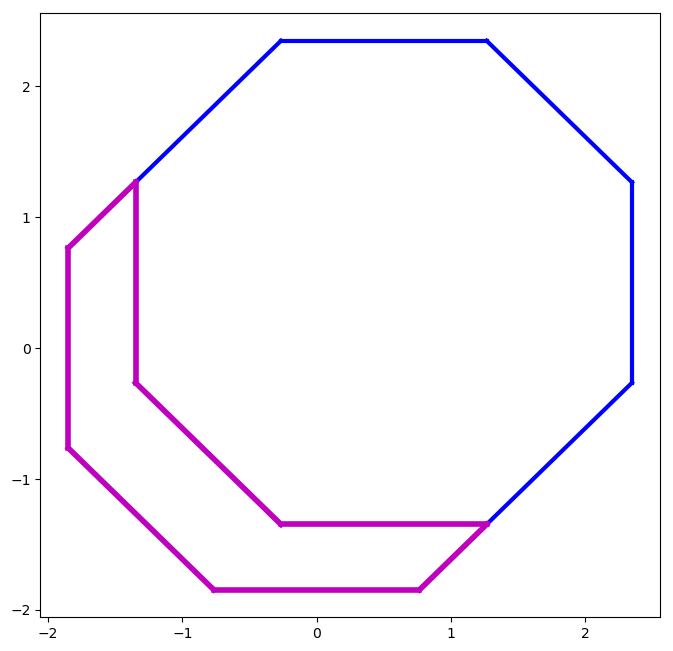

In [5]:
a = Loops([vec3.O().ring(2, 8)])
b = Loops([vec3.U(0.5).xy().ring(2, 8)])

def test_booleans():
    u = a.union(b)
    i = a.intersect(b)
    d = a.difference(b)
    
    f, ax = plot()
    a.plot(ax, col='g')
    b.plot(ax, col='b')
    u.plot(ax, col='m', lw=4)
    #plot_loop(ax, a.ps, col='g')
    #plot_loop(ax, b.ps, col='b')
    #for p in u:
    #    plot_loop(ax, p.ps, col='m', lw=4)
    #    for t in p.triangulation().simplices():
    #        plot_loop(ax, list(t), col='y', lw=2)
    
    f, ax = plot()
    a.plot(ax, col='g')
    b.plot(ax, col='b')
    i.plot(ax, col='m', lw=4)
    #plot_loop(ax, a.ps, col='g')
    #plot_loop(ax, b.ps, col='b')
    #for p in i:
    #    plot_loop(ax, p.ps, col='m', lw=4)
    #    for t in p.triangulation().simplices():
    #        plot_loop(ax, list(t), col='y', lw=2)
    
    f, ax = plot()
    a.plot(ax, col='g')
    b.plot(ax, col='b')
    d.plot(ax, col='m', lw=4)
    #plot_loop(ax, a.ps, col='g')
    #plot_loop(ax, b.ps, col='b')
    #for p in d:
    #    plot_loop(ax, p.ps, col='m', lw=4)
    #    for t in p.triangulation().simplices():
    #        plot_loop(ax, list(t), col='y', lw=2)
    
test_booleans()

In [6]:
def tests():
    l1 = Loops([vec3.O().ring(2, 8)])
    assert l1.N.isnear(vec3.Z())
    assert isnear(l1.area, 11, 1)
    
    l2 = l1.edgesplit(1)
    print(len(l1.loops[0]), len(l2.loops[0]))
    assert (len(l2.loops[0]) == len(l1.loops[0]) * 2)
    
    l3 = l1.cp().smooth(iterations=2)
    l4 = l1.cp().smooth(iterations=4)
    
    l5 = l1.cp().rot(quat.toxy(vec3.X()))
    l6 = l5.offset(0.01)
    print(l5.area)
    print(l6.area)
    
    l7s = l5.intersect(l6)
    #print([l.area for l in l7s])
    print(l7s.area)
    
    f, ax = plot()
    l1.plot(ax, col='b', lw=8)
    l2.plot(ax, col='r', lw=5)
    l3.plot(ax, col='g', lw=2)
    l4.plot(ax, col='g', lw=2)
    #plot_loop(ax, l1.ps, col='b', lw=8)
    #plot_loop(ax, l2.ps, col='r', lw=5)
    #plot_loop(ax, l3.ps, col='g', lw=2)
    #plot_loop(ax, l4.ps, col='g', lw=2)
    
tests()

8 16
11.314279840000001
11.19233086


AssertionError: 

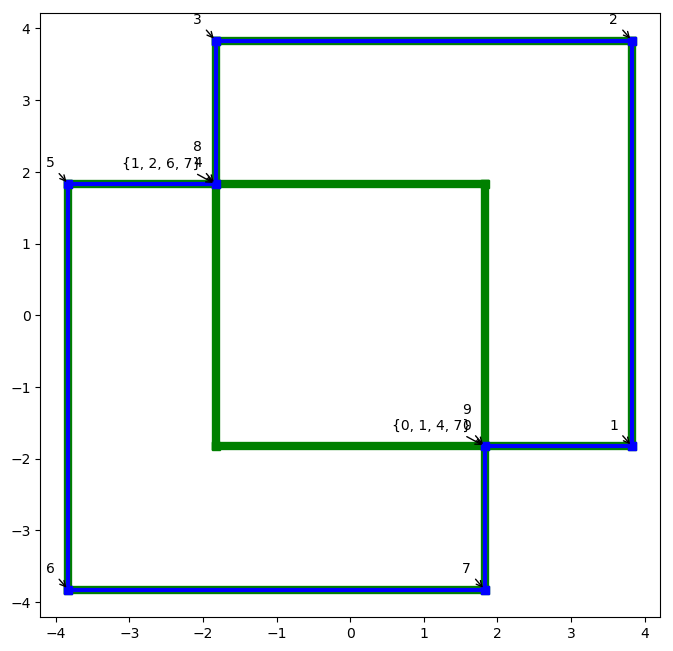

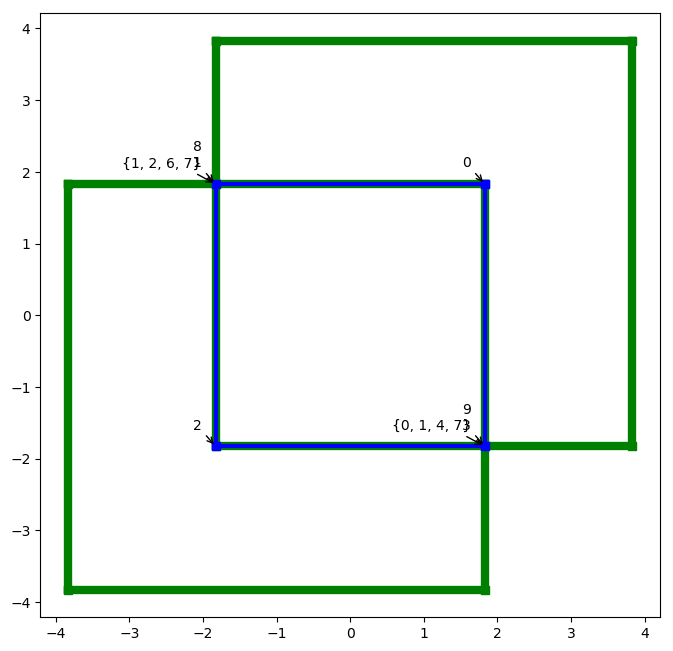

In [8]:
def test():
    l1, l2 = vec3(-1, -1, 0).ring(4, 4), vec3(1, 1, 0).ring(4, 4)

    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    
    f, ax = plot()
    plot_pg(ax, pg, lw=6, col='g', mk='s')
    #union = loop_union(l1, l2)
    #union = [x.ps for x in Loops([l1]).union(Loops([l2]))]
    union = Loops([l1]).union(Loops([l2]))
    union.plot(ax, lw=3, col='b', mk='s')
    #for u in union:
    #    plot_loop(ax, u, lw=3, col='b', mk='s')

    #f, ax = plot()
    #plot_pg(ax, pg, lw=6, col='g', mk='s')
    
    #diff = loop_difference(l1, l2)
    #for d in diff:
    #    plot_loop(ax, d, lw=3, col='b', mk='s')

    f, ax = plot()
    plot_pg(ax, pg, lw=6, col='g', mk='s')
    #intersection = loop_intersection(l1, l2)
    intersection = Loops([l1]).intersect(Loops([l2]))
    intersection.plot(ax, lw=3, col='b', mk='s')
    #for i in intersection:
    #    plot_loop(ax, i, lw=3, col='b', mk='s')
    
test()